In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a CLARITY brain to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

First we'll download the atlas image

In [3]:
refToken = "ara_ccf3"
refImg = imgDownload(refToken) 

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [4]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

269.129411765


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

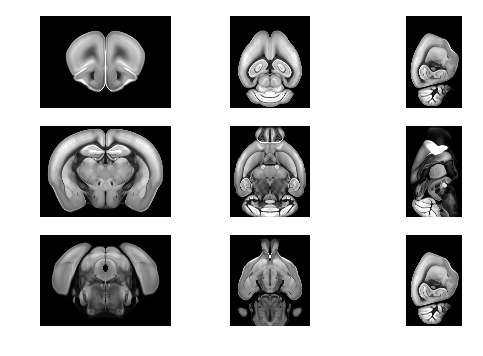

In [5]:
imgShow(refImg, vmax=refThreshold)

## Downloading CLARITY brain
Our *input* image will be CLARITY brain AutA.  At full resolution, CLARITY brains can be 1 Terabyte in size, far to large to be downloaded to a personal computer.  Thus *ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [6]:
inToken = "AutA"

nd = neurodata()
resolutionList = nd.get_metadata(inToken)['dataset']['voxelres'].keys()
lowestResolution = int(max(resolutionList))
print(lowestResolution)

5


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [7]:
inImg = imgDownload(inToken, resolution=lowestResolution)

Once again we'll only use intensity values below the 99th percentile in the visualization.

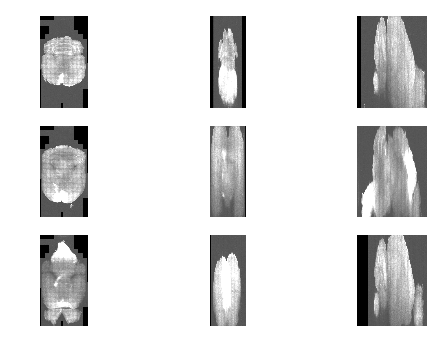

In [8]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

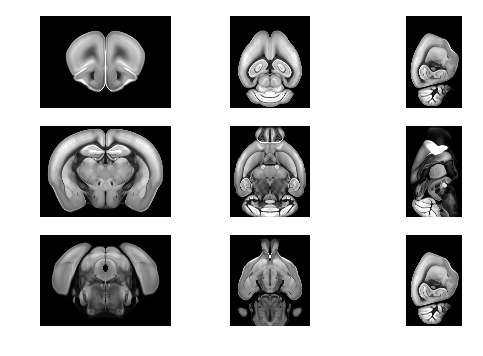

In [9]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

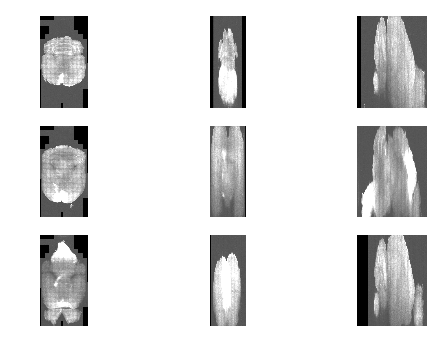

In [10]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **R**ight to left, the y-axis goes from **P**osterior to Anterior and the Z axis goes from **S**uperior to Inferior.  Thus it's in **RPS** orientation.  Therefore we reorient the CLARITY image from **RPS** to **RSA**

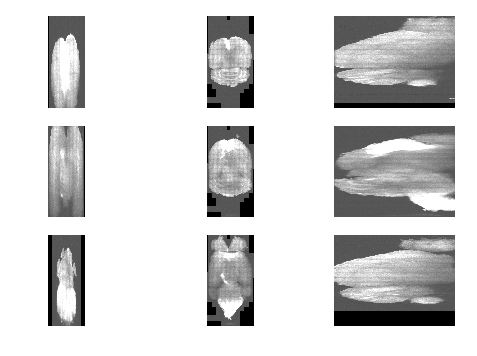

In [11]:
inOrient = "RPS"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [12]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [13]:
print(inImg.GetSpacing())

(0.01872, 0.005, 0.01872)


In [14]:
print(refImg.GetSpacing())

(0.01, 0.01, 0.01)


Since we are aliging the CLARITY image to a lower resolution atlas we resample it to the resolution atlas.

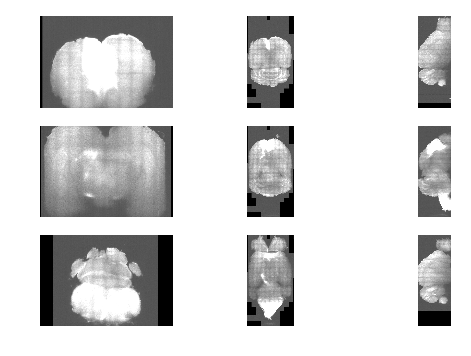

In [15]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=inThreshold)

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

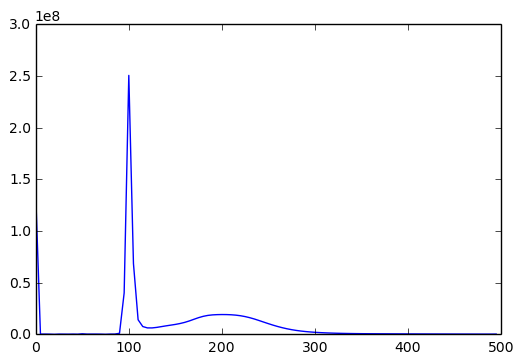

In [16]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.  Notice how we've recalculate the visualization threshold "inThreshold" since we've changed the intensity of the input image.

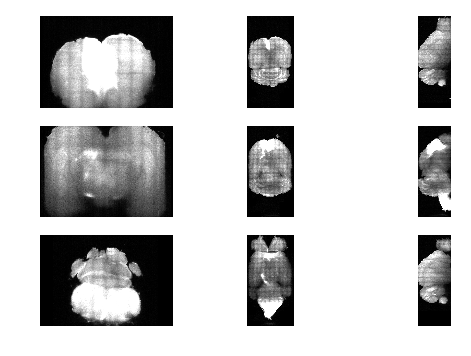

In [17]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
inThreshold -= lowerThreshold

imgShow(inImg, vmax=inThreshold)

Here's a histogram of the result

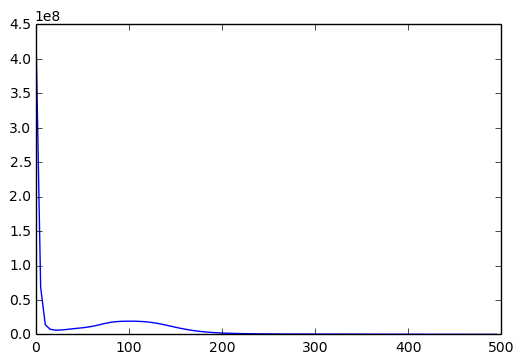

In [18]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

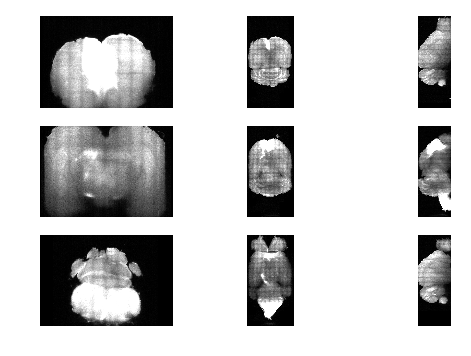

In [19]:
imgShow(inImg, vmax=inThreshold)

To avoid this problem we create a mask which will be used to exclude the top 5% brighest voxels (95th percentile) from registration.

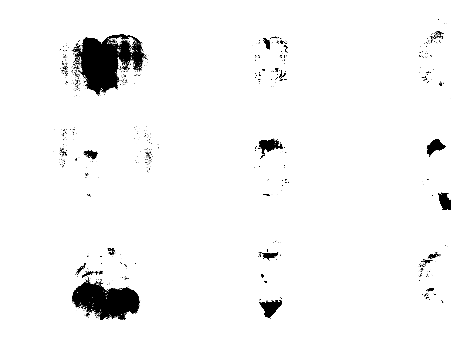

In [23]:
inMask = sitk.BinaryThreshold(inImg, 0, imgPercentile(inImg, 0.95), 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

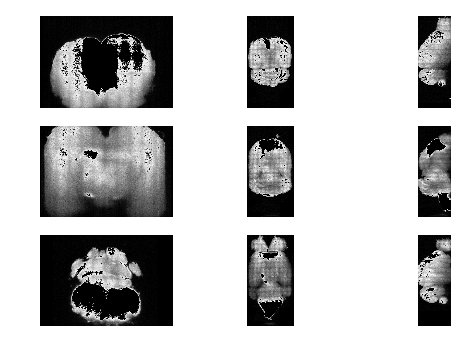

In [24]:
imgShow(imgMask(inImg,inMask))

## Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full atlas scale of 0.01 mm x 0.01 x 0.01 mm but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.1 mm x 0.1mm x 0.1mm

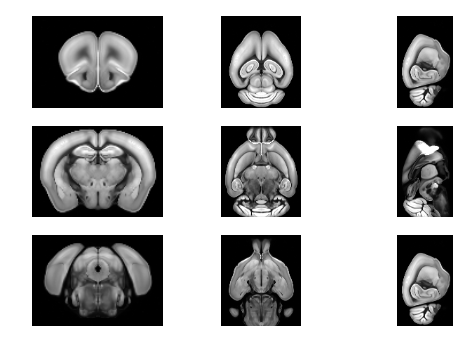

(114, 80, 132)


In [25]:
spacing=[0.1,0.1,0.1]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=refThreshold)
print(refImg_ds.GetSize())

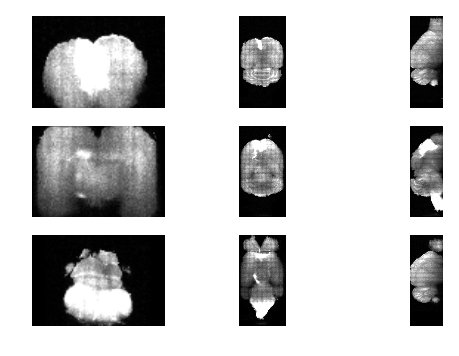

In [26]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=inThreshold)

Notice how we used nearest-neighbor interpolation when downsampling the mask

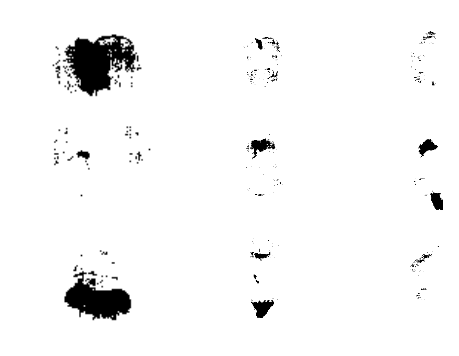

In [27]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [28]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.215544932123
1.	 -0.225581345106
2.	 -0.237191289399
3.	 -0.251394987582
4.	 -0.262825557871
5.	 -0.274978582224
6.	 -0.286202693273
7.	 -0.300950903182
8.	 -0.318028753144
9.	 -0.32930380129
10.	 -0.341763814982
11.	 -0.356201901442
12.	 -0.36823403629
13.	 -0.378879320804
14.	 -0.38593053155
15.	 -0.394391914927
16.	 -0.400314984453
17.	 -0.400146942962
18.	 -0.405009208573
19.	 -0.401540571509
20.	 -0.399962041852
21.	 -0.402492921968
22.	 -0.399724928585
23.	 -0.400120974776
24.	 -0.402434555864
25.	 -0.402448700708
26.	 -0.400314218073
27.	 -0.402523520763
28.	 -0.40022499812
Step rigid:
0.	 -0.419283079879
1.	 -0.316644645001
2.	 -0.412762040092
3.	 -0.400414953617
4.	 -0.444957120189
5.	 -0.441624442705
6.	 -0.454002607758
7.	 -0.451059432135
8.	 -0.455330425195
9.	 -0.457639377221
10.	 -0.461060682753
11.	 -0.460597579136
12.	 -0.462252452773
13.	 -0.462630850838
14.	 -0.46451176582
15.	 -0.463994657429
16.	 -0.465052419666
17.	 -0.465546135796
18.	 -0.

Now we apply the affine transform to the input CLARITY image and mask

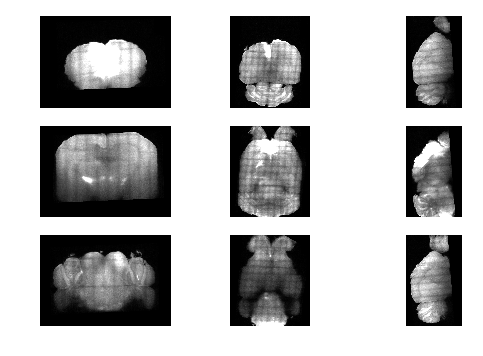

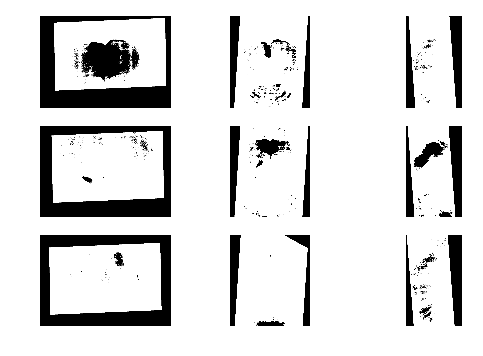

In [29]:
inImg = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg, vmax=inThreshold)

inMask = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.


Step 0: alpha=0.05, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.91258e+10, 0.0574651, 0, -1.91258e+10 (99.7705%), 2.148438e-06
1.	-1.91997e+10, 0.124952, 0, -1.91997e+10 (99.6985%), 2.363281e-06
2.	-1.92785e+10, 0.247848, 0, -1.92785e+10 (99.6218%), 2.599609e-06
3.	-1.93228e+10, 0.436909, 0, -1.93228e+10 (99.5787%), 2.859570e-06
4.	-1.93654e+10, 0.535026, 0, -1.93654e+10 (99.5372%), 1.572764e-06
5.	-1.93701e+10, 0.598129, 0, -1.93701e+10 (99.5326%), 8.650200e-07
6.	-1.94309e+10, 0.672581, 0, -1.94309e+10 (99.4735%), 9.515220e-07
7.	-1.9432e+10, 0.692485, 0, -1.9432e+10 (99.4724%), 2.616686e-07
8.	-1.94365e+10, 0.71525, 0, -1.94365e+10 (99.468%), 2.878354e-07
9.	-1.94408e+10, 0.740806, 0, -1.94408e+10 (99.4638%), 3.166190e-07
10.	-1.94474e+10, 0.769785, 0, -1.94474e+10 (99.4574%), 3.482808e-07
11.	-1.94517e+10, 0.80205, 0, -1.94517e+10 (99.4532%), 3.831089e-07
12.	-1.94562e+10, 0.839601, 0, -1.94562e+10 (99.4489%), 4.214198e-07
13.	-1.94652e+10

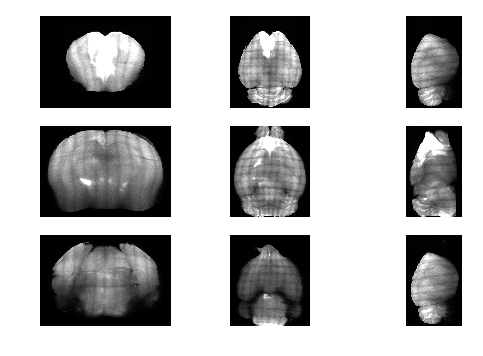

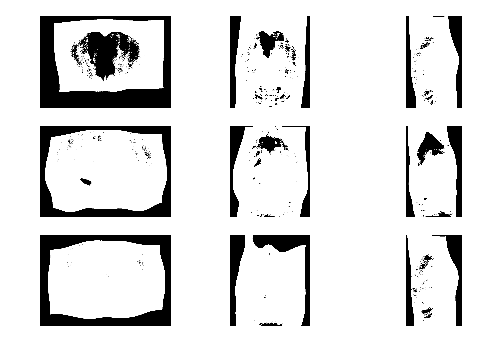

In [30]:
inImg_ds = imgResample(inImg, spacing=spacing)
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], scaleList = [0.25, 0.5, 1.0], useMI=True, iterations=100, verbose=True)
inImg = imgApplyField(inImg, field, size=refImg.GetSize())
inMask = imgApplyField(inMask, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg, vmax=inThreshold)
imgShow(inMask)

## Evaluating the registration
### Evaluation using checker board
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

In [ ]:
imgShow(imgChecker(inImg, refImg, useHM=False), vmax=refThreshold, numSlices=1)

## Uploading Results

### Uploading deformed CLARITY image
We can now upload the ARA-aligned CLARITY brain back into ndstore.

In [ ]:
token = "AutA_to_ara3"
imgUpload(inImg, token)

### Uploading deformed ARA annotations

To save memory we clear the reference image since it's no longer needed.

In [ ]:
refImg = None

Now we download the ARA annotations

In [ ]:
refAnnoImg = imgDownload(refToken, channel="annotation")

In [ ]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the ARA annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the ARA space to the space before registration.

In [ ]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

Were not done yet.  We still need to reorient these annotations from **RSA** to **RPS** 

In [ ]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

We can upload these annotations at the lowest possible resolution.

In [ ]:
outToken = "ara3_to_AutA"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)